# Main Notebook to Perform Trading

### Imports

In [1]:
import matplotlib.pyplot as plt

from data_collection import get_historical_data
from computing import compute_momentum, compute_mean_reversion, compute_signal_returns
from signals import generate_signals_momentum, generate_signals_meanreversion, generate_final_signal
from trading import build_strategy_choice_label, build_feature_matrix, track_strategy_chosen_signals
from training import train_strategy_chooser
from analysis import count_strategy_choices, build_trade_log, get_trades_for_stock
from risk_management import apply_stop_loss

### Get Data

In [2]:
tickers = [
    # Focus on Tech Company Stocks
    "AAPL",  # Apple
    "MSFT",  # Microsoft
    "GOOG",  # Alphabet
    "AMZN",  # Amazon
    "META",  # Meta
    "NVDA",  # NVIDIA
    "IBM",   # IBM
    "ORCL",  # Oracle
    "INTC",  # Intel
    "ADBE",  # Adobe
    "CRM",   # Salesforce
    "TSLA",  # Tesla

    # Benchmark
    "SPY"    # S&P 500
]


# Download historical data
start_date = "2019-12-31"
end_date = "2024-12-31"
data = get_historical_data(tickers, start=start_date, end=end_date)
spy_series = data["SPY"] # S&P 500

print("Historical Data Shape:", data.shape)
display(data.tail())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Historical Data Shape: (1258, 13)


,AAPL,MSFT,GOOG,AMZN,META,NVDA,IBM,ORCL,INTC,ADBE,CRM,TSLA,SPY
Date,,,,,,,,,,,,,
2024-12-23,255.270004,435.250000,195.990005,225.059998,599.849976,139.669998,221.929993,168.725281,20.200001,446.739990,342.899994,430.600006,594.690002
2024-12-24,258.200012,439.329987,197.570007,229.050003,607.750000,140.220001,224.410004,170.989731,20.400000,447.940002,344.429993,462.279999,601.299988
2024-12-26,259.019989,438.109985,197.100006,227.050003,603.349976,139.929993,224.889999,171.259048,20.440001,450.160004,341.720001,454.130005,601.340027
2024-12-27,255.589996,430.529999,194.039993,223.750000,599.809998,137.009995,222.779999,168.545731,20.299999,446.480011,338.450012,431.660004,595.010010
2024-12-30,252.199997,424.829987,192.690002,221.300003,591.239990,137.490005,220.250000,166.500763,19.820000,445.799988,335.739990,417.410004,588.219971


### Compute Signals

In [3]:
# Compute Momentum & Mean-Reversion
momentum_df = compute_momentum(data, window=63)  # 3-month
zscore_df   = compute_mean_reversion(data, window=20)

In [4]:
# Generate separate signals
momentum_signals = generate_signals_momentum(momentum_df, threshold=0.10) # 10%
meanrev_signals = generate_signals_meanreversion(zscore_df, z_entry=1.0)

In [5]:
# Compute next-day returns from each approach
momentum_returns = compute_signal_returns(data, momentum_signals)
meanrev_returns = compute_signal_returns(data, meanrev_signals)
label = build_strategy_choice_label(momentum_returns, meanrev_returns)

### Train Model

In [6]:
# Build features & train the "strategy chooser"
features = build_feature_matrix(data, momentum_df, zscore_df, vol_window=20)
clf = train_strategy_chooser(features, label)

Best Params: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 50}
Best CV Score: 0.5460251046025104


### Results

In [7]:
# Generate the signals day by day based on classifier
signals = generate_final_signal(
    clf,
    features,
    momentum_signals,
    meanrev_signals
)

# Apply stop-loss to the signals
final_signals = apply_stop_loss(signals, data, 0.05)

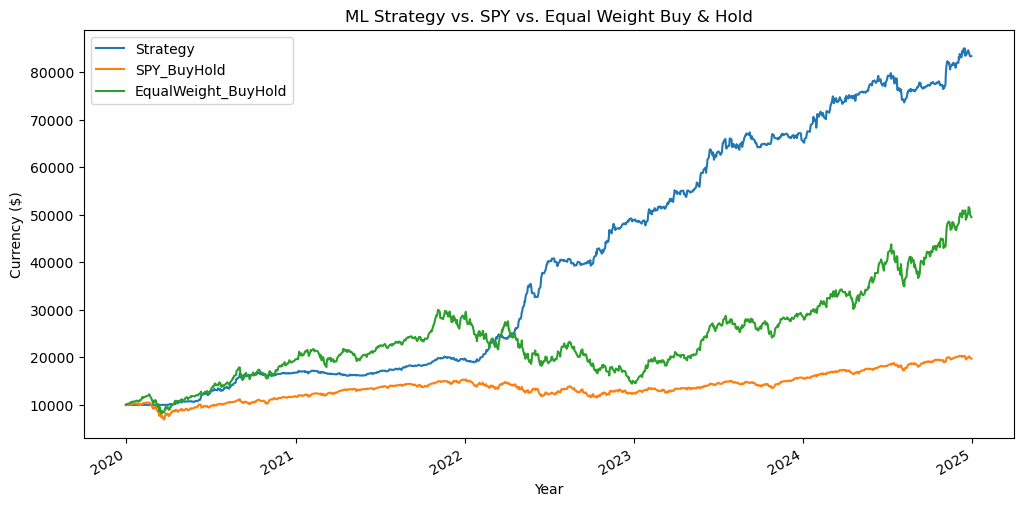

                Strategy   SPY_BuyHold  EqualWeight_BuyHold
Date                                                       
2024-12-23  84571.734776  19929.006730         50423.924943
2024-12-24  84295.783587  20150.517840         51588.030048
2024-12-26  83594.226144  20151.859613         51290.006556
2024-12-27  83314.392446  19939.730684         50033.804575
2024-12-30  83314.392446  19712.185688         49479.565254


In [8]:
# Track performance
result_df = track_strategy_chosen_signals(data.dropna(), final_signals, spy_series)

# Plot all three equity curves
result_df[['Strategy', 'SPY_BuyHold', 'EqualWeight_BuyHold']].plot(
    figsize=(12, 6), title="ML Strategy vs. SPY vs. Equal Weight Buy & Hold"
)
plt.ylabel("Currency ($)")
plt.xlabel("Year")
plt.show()

print(result_df.tail())

### Testing and Analysis

In [9]:
n_mom, n_mr = count_strategy_choices(clf, features)

Momentum chosen:       912 days
Mean Reversion chosen: 283 days


In [10]:
trade_log = build_trade_log(final_signals, data)
print(trade_log.head(10))

        Date Ticker     Action       Price
0 2020-02-24   AAPL  OPEN_LONG   72.441597
1 2020-02-24    SPY  OPEN_LONG  298.923492
2 2020-02-24     BA  OPEN_LONG  317.899994
3 2020-02-24   SBUX  OPEN_LONG   76.311768
4 2020-02-24     GS  OPEN_LONG  198.675735
5 2020-02-24    JNJ  OPEN_LONG  127.821838
6 2020-02-24    DIS  OPEN_LONG  131.386887
7 2020-02-24    PEP  OPEN_LONG  123.541054
8 2020-02-24   INTC  OPEN_LONG   54.746277
9 2020-02-24   ORCL  OPEN_LONG   48.836918


Total trades for AAPL: 428

Showing the first 5 trades for AAPL:

          Date Ticker       Action      Price
0   2020-02-24   AAPL    OPEN_LONG  72.441597
24  2020-02-25   AAPL   CLOSE_LONG  69.987831
62  2020-04-02   AAPL   OPEN_SHORT  59.504719
84  2020-04-03   AAPL  CLOSE_SHORT  58.649555
110 2020-04-08   AAPL   OPEN_SHORT  64.640587


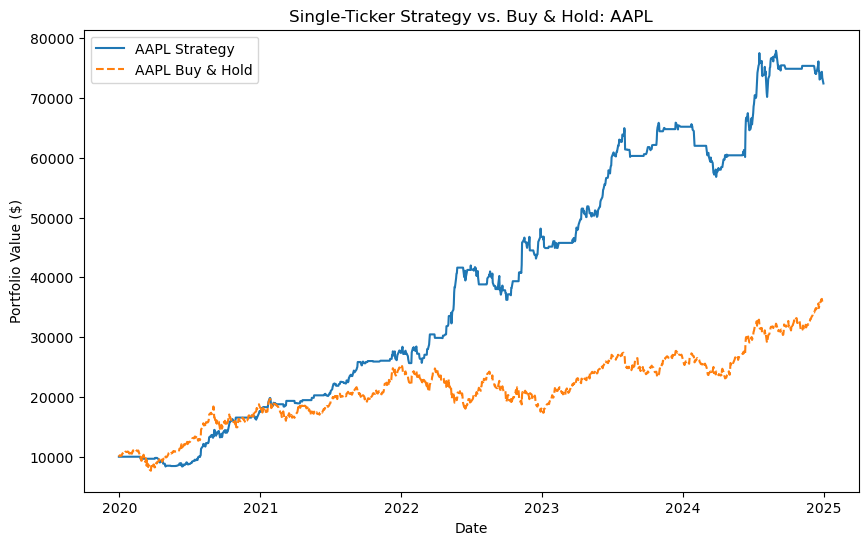

In [14]:
filtered_trades, equity, buyhold = get_trades_for_stock(
    trade_log_df=trade_log,
    final_signals=final_signals,
    price_data=data,
    ticker='AAPL', # Some good: MSFT, AAPL, Some bad: BA
    show_trade_count=5,
    initial_capital=10000.0
)